In [16]:
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


import carly

## Read Data

In [3]:
def model_preprocessing(input_df):
    
    input_df = input_df.drop(columns = ['eco_category', # same value for all records
                                        'indicative_price', # same value for all records
                                        'lifespan', #more than 90% of records null values 
                                       ])
    
    ####################### data processing ######################
    ##############################################################
    
    input_df    = carly.dataproc.DEDUP_listingid(df = input_df)
    
    input_df    = carly.dataproc.FIXNULL_make(df = input_df)
    input_df    = carly.dataproc.FIXNULL_manufacture(df = input_df)
    input_df    = carly.dataproc.FIXNULL_ownercount(df = input_df)
    input_df    = carly.dataproc.FIXNULL_dereg(df = input_df)
    input_df    = carly.dataproc.FIXNULL_fueltype(df = input_df)
    
    input_df    = carly.dataproc.ENCODE_category(df = input_df, drop = False)
    input_df    = carly.dataproc.ENCODE_transmission(df = input_df, drop=True)
    input_df    = carly.dataproc.ENCODE_vehtype(df = input_df, drop=False)
    input_df    = carly.dataproc.ENCODE_make(df = input_df, drop=False)
    input_df    = carly.dataproc.ENCODE_fueltype(df = input_df, drop=False)
    input_df    = carly.dataproc.ENCODE_model(df = input_df, drop=False)
    input_df    = carly.dataproc.ENCODE_opcscheme(df = input_df)
    
    input_df    = carly.dataproc.EXTRACT_features(df = input_df)
    input_df    = carly.dataproc.EXTRACT_desc(df = input_df)
    input_df    = carly.dataproc.EXTRACT_accessories(df = input_df)
    
    input_df    = carly.dataproc.CALC_currentage(df = input_df)
    input_df    = carly.dataproc.CALC_remainage(df = input_df)
    
    input_df    = carly.dataproc.IMPUTENULL_power(df = input_df)
    input_df    = carly.dataproc.IMPUTENULL_curbweight(df = input_df)
    input_df    = carly.dataproc.IMPUTENULL_enginecap(df = input_df)
    input_df    = carly.dataproc.IMPUTENULL_depreciation(df = input_df)
    input_df    = carly.dataproc.IMPUTENULL_omv(df = input_df)
    input_df    = carly.dataproc.IMPUTENULL_arf(df = input_df)
    input_df    = carly.dataproc.IMPUTENULL_mileage(df = input_df)
    input_df    = carly.dataproc.IMPUTENULL_roadtax(df = input_df)
    
    input_df    = carly.dataproc.RATIO_ownertoage(df = input_df)
    input_df    = carly.dataproc.RATIO_miletoage(df = input_df)
    input_df    = carly.dataproc.RATIO_curbtopower(df = input_df)
    input_df    = carly.dataproc.RATIO_indirectcost(df = input_df)
    input_df    = carly.dataproc.RATIO_ARFtoOMV(df = input_df)
    input_df    = carly.dataproc.RATIO_ARFtoDEREG(df = input_df)
    input_df    = carly.dataproc.RATIO_miletoowner(df = input_df)

    ### enable categorical without encoding ######################
    ##############################################################
    
    cat_features = ["make", "type_of_vehicle", "fuel_type", "model", "CAT-elechybrid", "CAT-coeparf",]
    input_df[cat_features] = input_df[cat_features].astype('category')
    
    return input_df

/Users/jiayonghong/Desktop/workspace/CS5228-Kaggle-Project/carly/dataproc.py:346: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['opc_scheme'] = df['opc_scheme'].fillna(0)  # Fill remaining nulls with 0
/Users/jiayonghong/Desktop/workspace/CS5228-Kaggle-Project/carly/dataproc.py:346: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['opc_scheme'] = df['opc_scheme'].fillna(0)  # Fill remaining nulls with 0


Number of components to retain 90% variance: 52


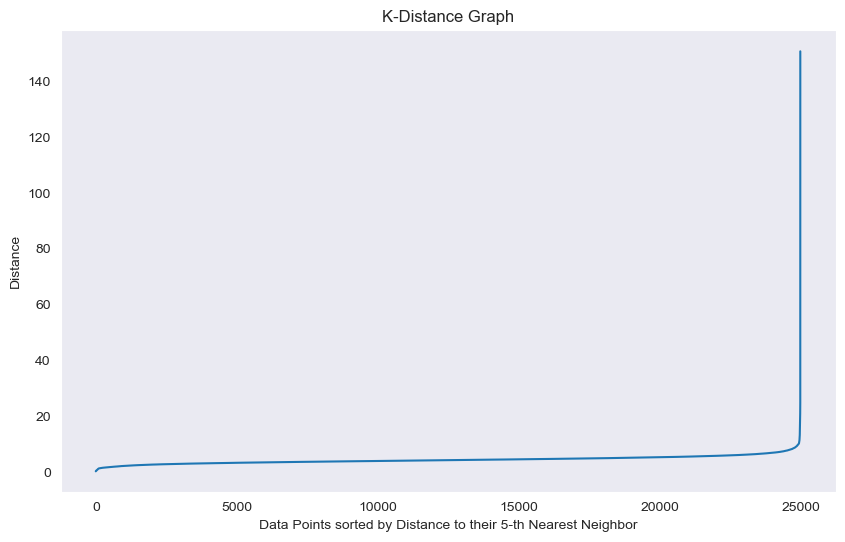

Anomalies found: 267


In [4]:
train_df_RAW                    = pd.read_csv(r"./dataset/train.csv")
test_df_RAW                     = pd.read_csv(r"./dataset/test.csv")
cat_encoding                    = True

train_df                        = model_preprocessing(input_df = train_df_RAW)
train_df_base, train_df_eval    = train_test_split(train_df, test_size=0.2, random_state=888888)
test_df                         = model_preprocessing(input_df = test_df_RAW)

# ### Remove outliers from training dataset
train_df        = train_df.loc[~(train_df['AGE-remaining']<0) | ~(train_df['AGE-currentREG']<0)]
outlier_df      = carly.outlier_detection.identify_outliers(df=train_df)
train_df        = outlier_df.loc[(outlier_df['cluster']!=-1) & (outlier_df['CAT-rare&exotic']!=1)].drop(columns=['cluster'])

In [7]:
feature_list = carly.params.ENCODED_feature_list 
target = carly.params.target

In [23]:

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model = RandomForestRegressor(**{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}
)
rf_model.fit(train_df_base[feature_list], train_df_base[target])

y_pred_eval_rf = rf_model.predict(train_df_eval[feature_list])

In [42]:
"""
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf_model_tune = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_model_tune, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params
"""


"\nparam_grid = {\n    'n_estimators': [100, 200, 300],\n    'max_depth': [10, 20],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'max_features': ['auto', 'sqrt']\n}\n\nrf_model_tune = RandomForestRegressor(random_state=42)\n\ngrid_search = GridSearchCV(estimator=rf_model_tune, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)\n\ngrid_search.fit(X_train, y_train)\n\nbest_params = grid_search.best_params_\nbest_params\n"

In [24]:
# rf_model = RandomForestRegressor(**{'max_depth': 20,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'n_estimators': 200})

## Evaluation on Random Forest & Linear Regression

In [25]:
mean_absolute_error(train_df_eval[target], y_pred_eval_rf)

6516.116285857217

In [26]:
root_mean_squared_error(train_df_eval[target], y_pred_eval_rf)

25143.354073252493

In [27]:
r2_score(train_df_eval[target], y_pred_eval_rf)

0.9727464774874808

In [28]:
linear_model = LinearRegression()

In [29]:
linear_model.fit(train_df_base[feature_list], train_df_base[target])

LinearRegression()

In [30]:
y_pred_eval_lr = linear_model.predict(train_df_eval[feature_list])

In [31]:
mean_absolute_error(train_df_eval[target], y_pred_eval_lr)

10601.547971758142

In [32]:
root_mean_squared_error(train_df_eval[target], y_pred_eval_lr)

27648.922283092077

In [33]:
r2_score(train_df_eval[target], y_pred_eval_lr)

0.9670441410217949

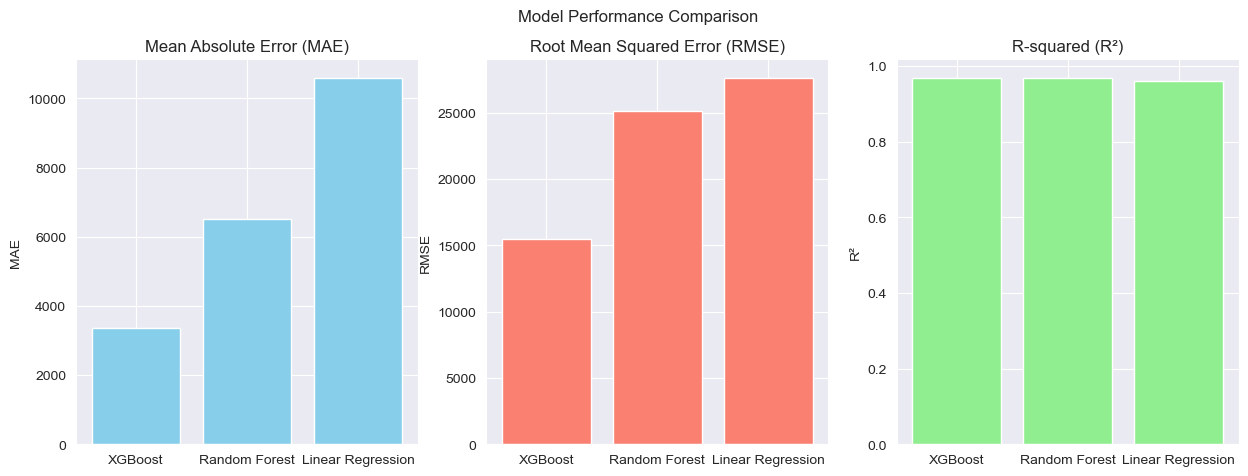

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for each model
models = ['XGBoost', 'Random Forest', 'Linear Regression']
mae = [3374.38, 6516.12, 10601.54]
rmse = [15461.67, 25143.35, 27648.92]
r2 = [0.97, 0.97, 0.96]

# Create subplots for each metric
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot MAE
axs[0].bar(models, mae, color='skyblue')
axs[0].set_title('Mean Absolute Error (MAE)')
axs[0].set_ylabel('MAE')

# Plot RMSE
axs[1].bar(models, rmse, color='salmon')
axs[1].set_title('Root Mean Squared Error (RMSE)')
axs[1].set_ylabel('RMSE')

# Plot R-squared
axs[2].bar(models, r2, color='lightgreen')
axs[2].set_title('R-squared (R²)')
axs[2].set_ylabel('R²')

plt.suptitle('Model Performance Comparison')
plt.show()